## Perceptron Learning Rule

Last revision: Martin Melchior - 18.09.2019

In this exercise you implement the perceptron learning rule. Then you apply it to linearly separable data (the data can be generated on the fly) and you can convince yourself that your system is properly implemented and has found the separating line. 

Some emphasis should be given to properly handle numpy arrays. These will be much more extensively used in upcoming exercises of later weeks. So, we recommend to take a serious glance at them.


### Preparation of the Data

Instead of providing a fixed input dataset, we here generate it randomly.
For easier comparison, we want to make sure that the same data is produced. Therefore, we set a random seed (set to 1 below).

The data will be generated in form of a 2d array, the first index enumerating the dimensions (rows, in the 2d case index 0 and 1), the second enumerating the samples (columns). 

Furthermore, we provide a suitable plotting utility that allows you to inspect the generated data.

In [1]:
import numpy as np

def prepare_data(m,m1,a,s,width=0.6,eps=0.5, seed=1):
    """
    Generates a random linearly separable 2D test set and associated labels (0|1).
    The x-values are distributed in the interval [-0.5,0.5]. 
    With the parameters a,s you can control the line that separates the two classes. 
    This turns out to be the line with the widest corridor between the two classes (with width 'width').
    If the random seed is set, the set will always look the same for given input parameters. 
    
    Arguments:
    a -- y-intercept of the seperating line
    s -- slope of the separating line
    m -- number of samples
    m1 -- number of samples labelled with '1'
    width -- width of the corridor between the two classes
    eps -- measure for the variation of the samples in x2-direction
    
    Returns:
    x -- generated 2D data of shape (2,n)
    y -- labels (0 or 1) of shape (1,n)
    """
    np.random.seed(seed)
    idx = np.random.choice(m, m1, replace=False)
    y = np.zeros(m, dtype=int).reshape(1,m)
    y[0,idx] = 1
    
    x = np.random.rand(2,m).reshape(2,m) # random numbers uniformly distributed in [0,1]
    x[0,:]-= 0.5
    idx1 = y[0,:]==1
    idx2 = y[0,:]==0
    x[1,idx1] = (a+s*x[0,idx1]) + (width/2+eps*x[1,idx1])
    x[1,idx2] = (a+s*x[0,idx2]) - (width/2+eps*x[1,idx2])
    
    return x,y

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def line(a, s, n=100):
    """    
    Returns a line 2D array with x and y=a+s*x.
    
    Parameters:
    a -- intercept
    s -- slope
    n -- number of points
    
    Returns:
    2d array of shape (n,2) 
    """
    x = np.linspace(-0.5, 0.5, n)
    l = np.array([x,a+s*x]).reshape(2,n)
    return l

def plot(x, y, params_best=None, params_before=None, params_after=None, misclassified=None, selected=None):
    """
    Plot the 2D data provided in form of the x-array. 
    Use markers depending on the label ('1 - red cross, 0 - blue cross').
    Optionally, you can pass tuples with parameters for a line (a: y-intercept, s: slope) 
    * params_best: ideal separating line (green dashed) 
    * params: predicted line (magenta)
    Finally, you can also mark single points:
    * misclassified: array of misclassified points (blue circles)
    * selected: array of selected points (green filled circles)
    
    Parameters:
    x -- 2D input dataset of shape (2,n)
    y -- ground truth labels of shape (1,n)
    params_best -- parameters for the best separating line
    params -- any line parameters
    misclassified -- array of points to be marked as misclassified
    selected -- array of points to be marked as selected
    """
    idx1 = y[0,:]==1
    idx2 = y[0,:]==0
    plt.plot(x[0,idx1], x[1,idx1], 'r+', label="label 1")
    plt.plot(x[0,idx2], x[1,idx2], 'b+', label="label 0")    
    if not params_best is None:
        a = params_best[0]
        s = params_best[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'g--')
    if not params_before is None:
        a = params_before[0]
        s = params_before[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'm--')
    if not params_after is None:
        a = params_after[0]
        s = params_after[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'm-')
    if not misclassified is None:
        plt.plot(x[0,misclassified], x[1,misclassified], 'o', label="misclassified")
    if not selected is None:
        plt.plot(x[0,selected], x[1,selected], 'oy', label="selected")
        
    plt.legend()
    plt.show()


#### Generate and Plot a Sample

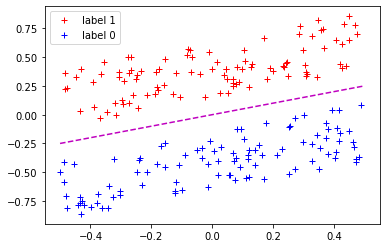

In [3]:
x,y = prepare_data(200,100,0,0.5,width=0.3,eps=0.5, seed=1)
plot(x, y, params_before=(0,0.5))

### Parameters for the decision boundary

Here, you should implement a function that translates the weights vector $(w_1,w_2)$ and the bias $b$ into parameters of a straight line ( $x_2 = a + s \cdot x_1$ )

In [4]:
def lineparams(weight, bias):
    """
    Translates the weights vector and the bias into line parameters with a x2-intercept 'a' and a slope 's'.

    Parameters:
    weight -- weights vector of shape (1,2)
    bias -- bias (a number)
    
    Returns:
    a -- x2-intercept
    s -- slope of the line in the (x1,x2)-plane
    """
    ### START YOUR CODE ###
    
    w1, w2 = weight[0]
    a = -bias / w2
    s = -w1 / w2
    
    ### END YOUR CODE ###
    return a,s

### Implement the Perceptron Learning Algorithm

by implementing the functions
* predict
* update
* select_datapoint
* train

Follow the descriptions of these functions.

In [5]:
def predict(x,w,b):
    """
    Computes the predicted value for a perceptron (single LTU).
    
    Parameters:
    x -- input dataset of shape (2,m)
    w -- weights vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    y -- prediction of a perceptron (single LTU) of shape (1,m)
    """
    ### START YOUR CODE ###
    yc = w.dot(x) + b
    y = np.heaviside(yc, 1)
    
    ### END YOUR CODE ###
    
    return y

def update(x,y,w,b,alpha=1.0):
    """
    Performs an update step in accordance with the perceptron learning algorithm.
    
    Parameters:
    x -- input data point of shape (2,1)
    y -- true label ('ground truth') for the specified point
    w -- weight vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    w1 -- updated weight vector
    b1 -- updated bias
    """
    ypred = predict(x,w,b)

    ### START YOUR CODE ###
    w1 = w - alpha * (ypred - y) * x
    b1 = b - alpha * (ypred - y)
    ### END YOUR CODE ###

    return w1, b1


def select_datapoint(x, y, w, b):
    """
    Identifies the misclassified data points and selects one of them.
    In case all datapoints are correctly classified None is returned. 

    Parameters:
    x -- input dataset of shape (2,m)
    y -- ground truth labels of shape (1,m)
    w -- weights vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    x1 -- one of the wrongly classified datapoint (of shape (2,1))
    y1 -- the associated true label
    misclasssified -- array with indices of wrongly classified datapoints or empty array
    """
    ypred = predict(x,w,b)
    wrong_mask = (ypred != y)[0]
    misclassified = np.where(wrong_mask)[0]
    if len(misclassified)>0:
        x1 = x[:,misclassified[0]]
        y1 = y[0,misclassified[0]]
        return x1, y1, misclassified
    return None, None, []

def train(weight_init, bias_init, x, y, alpha=1.0, debug=False, params_best=None, max_iter=1000):
    """
    Trains the perceptron (single LTU) for the given data x and ground truth labels y
    by using the perceptron learning algorithm with learning rate alpha (default is 1.0).
    The max number of iterations is limited to 1000.
    
    Optionally, debug output can be provided in form of plots with showing the effect 
    of the update (decision boundary before and after the update) provided at each iteration.    
    
    Parameters:
    weight_init -- weights vector of shape (1,2)
    bias_init -- bias (a number)
    x -- input dataset of shape (2,m)
    y -- ground truth labels of shape (1,m)
    alpha -- learning rate
    debug -- flag for whether debug information should be provided for each iteration
    params_best -- needed if debug=True for plotting the true decision boundary
    
    Returns:
    weight -- trained weights
    bias -- trained bias
    misclassified_counts -- array with the number of misclassifications at each iteration
    """
    weight = weight_init
    bias = bias_init
    iterations = 0
    misclassified_counts = [] # we track them to show how the system learned in the end 
    
    ### START YOUR CODE ###
    
    # Getting a more ideal data structure
    xt = x.T
    yt = y.T
    xtest = 1
    while iterations<=max_iter and xtest is not None:
        xt = x.T
        yt = y.T
        for xi, yi in zip(xt, yt):
            weight, bias = update(xi, yi, weight, bias, alpha)
        
        xtest, ytest, misclassified = select_datapoint(x, y, weight, bias)
        misclassified_counts.append(len(misclassified))
        
        iterations += 1
    ### END YOUR CODE ###
        
    return weight, bias, misclassified_counts

#### Auxiliary Function

In [6]:
def weights_and_bias(a,s):
    """
    Computes weights vector and bias from line parameters x2-intercept and slope.
    """
    w1 = - s
    w2 = 1.0
    weight = np.array([w1,w2]).reshape(1,2)
    bias = - a
    return weight, bias

### Test Your Implementation

1/ Prepare the dataset by using the prepare_data function defined above and plot it. Use the parameters specified below (a=1, s=2, n=100, n1=50).

2/ Run the training with the default learning rate (alpha=1).
Paste the plots with the situation at the start and with the situation at the end of the training in a text document.
Paste also the start parameters (weight and bias) and trained parameters.

3/ Create a plot with the number of mis-classifications vs iteration.

#### 1/ Prepare the dataset

weight:  [[-2.  1.]]   bias:  -1


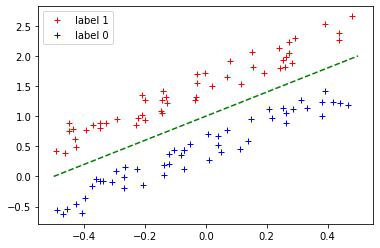

In [7]:
m = 100
m1 = 50
a = 1
s = 2
x,y = prepare_data(m,m1,a,s, seed=1)

params_best = (a,s)
weight_best, bias_best = weights_and_bias(a, s)
print("weight: ", weight_best, "  bias: ", bias_best)
plot(x,y,params_best=params_best)

#### 2/ Run the training

Initial Params:  [[0. 1.]] 0
(0.0, -0.0)


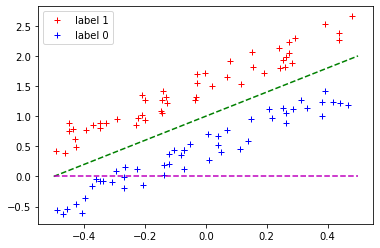

asdf:  [9, 14, 0]
Iterations:  2
Trained Params:  [[-4.30664293  2.63278478]] [-3.]


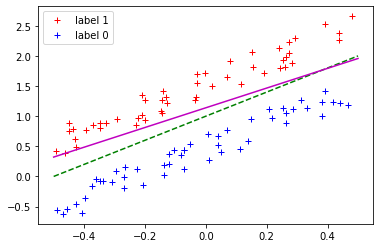

In [8]:
a1 = 0
s1 = 0
alpha = 1.0

weight1, bias1 = weights_and_bias(a1,s1)
print("Initial Params: ",weight1,bias1)
params = lineparams(weight1, bias1)
print(params)
plot(x,y,params_best, params)

weight1,bias1,misclassified_counts = train(weight1, bias1, x, y)
#weight1,bias1,misclassified_counts = train(weight1, bias1, x, y, debug=True, params_best=params_best)
params = lineparams(weight1, bias1)
print("asdf: ", misclassified_counts)
print("Iterations: ", len(misclassified_counts)-1)
print("Trained Params: ", weight1,bias1)
plot(x,y, params_best=params_best, params_after=params)


#### 3/ Create the plot with the misclassifications per iteration

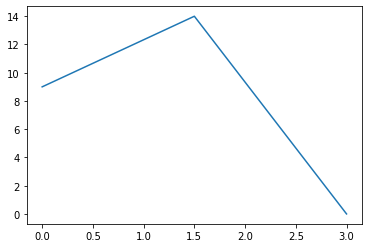

In [9]:
nit = len(misclassified_counts)
it = np.linspace(0,nit,nit)

_ = plt.plot(it, misclassified_counts)

In [79]:
# NOTE: The function is copied from a previous ML course taught by M. Graber, 2018 @ FHNW and adapted by us
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, weights, bias, resolution=0.02):
    markers = ('o', 'o', 'o', 'o', 'o')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    
    xx0 = np.array([bias]*len(xx1)).T
    xx0 = np.expand_dims(xx1, axis=1)
    test = np.array([xx1.ravel(), xx2.ravel()]).T
    
    ones = np.array([np.ones(test.shape[0])]).T
    
    Z = predict(test.T, weights, bias)
    Z = Z.reshape(xx1.shape)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[(y == cl)[:, 0], 0], y=X[(y == cl)[:, 0], 1], alpha=0.8, c=[cmap(idx)], 
                   marker=markers[idx], label=cl, edgecolor='none')
        
    _ = ax.set_xlabel('petal width')
    _ = ax.set_ylabel('sepal width')
    _ = ax.set_title('Decision region plot')
    plt.figtext(.25, -.01, 'Decision region plot of petal width and sepal width')
    return fig, ax

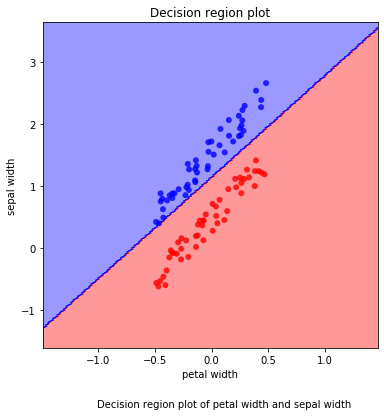

In [80]:
fig, ax = plot_decision_regions(x.T, y.T, weight1, bias1)